<a href="https://colab.research.google.com/github/eniktab/MoE_nlp/blob/master/HelloMoE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **To get good captions, you need to train the model well, which take a couple of days on a supercomputer **
but here to speed up things for this teaser, we will use a tiny subset of traning datas which will result in less accurate (but funnier) captioning. Sorry!?

We will use MS-COCO dataset comprising over 82,000 images, with at least five different annotations for each image. 
**Caution this requires downloading ~14GB!**
In brief, we teach the computer
1.  to look at an image and turn it into a tensor (multidimensional matrix)
like [[2,4,....,2,1] ..... [1,3...]]
2.  decide what a sequence of number like [2,4,....,2,1] means
3.  learn to speak in English a tell us what it saw 


```
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
forked from
https://www.tensorflow.org/

```




Set your image path: you can upload it at this website 
 get the link from --->>> https://imgur.com/upload 
 then copy past the link in this box --->>>  
Using the defualt image. Thank you Philip for your contribution!


  0%|          | 0/625 [00:00<?, ?it/s]

10000


100%|██████████| 625/625 [01:09<00:00,  8.95it/s]


Epoch 2 Batch 0 Loss 1.5826
Epoch 2 Batch 100 Loss 1.0410
Epoch 2 Batch 200 Loss 0.8169
Epoch 2 Batch 300 Loss 0.8284
Epoch 2 Batch 400 Loss 0.9075
Epoch 2 Batch 500 Loss 0.7407
Epoch 2 Batch 600 Loss 0.6972
Epoch 2 Batch 700 Loss 0.6983
Epoch 2 Loss 0.816742
Time taken for 1 epoch 167.49806666374207 sec

Epoch 3 Batch 0 Loss 0.6445
Epoch 3 Batch 100 Loss 0.7174
Epoch 3 Batch 200 Loss 0.6748
Epoch 3 Batch 300 Loss 0.6749
Epoch 3 Batch 400 Loss 0.6781
Epoch 3 Batch 500 Loss 0.7494
Epoch 3 Batch 600 Loss 0.6853
Epoch 3 Batch 700 Loss 0.7302
Epoch 3 Loss 0.679511
Time taken for 1 epoch 91.24229121208191 sec

Epoch 4 Batch 0 Loss 0.6678
Epoch 4 Batch 100 Loss 0.6224
Epoch 4 Batch 200 Loss 0.5991
Epoch 4 Batch 300 Loss 0.6513
Epoch 4 Batch 400 Loss 0.6265
Epoch 4 Batch 500 Loss 0.5894
Epoch 4 Batch 600 Loss 0.6208
Epoch 4 Batch 700 Loss 0.6310
Epoch 4 Loss 0.629332
Time taken for 1 epoch 90.89146041870117 sec

Epoch 5 Batch 0 Loss 0.6045
Epoch 5 Batch 100 Loss 0.6089
Epoch 5 Batch 200 Loss 

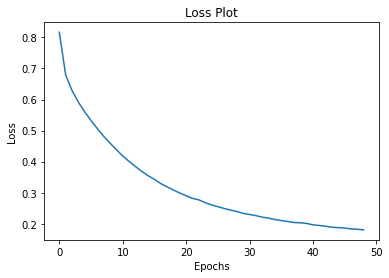

Prediction Caption: a man in a business suit is looking at someone <end>


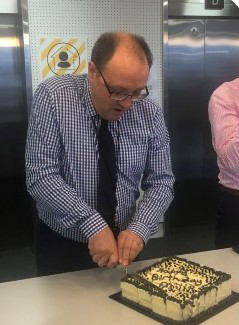

In [ ]:
import tensorflow as tf
from google.colab import files
import os
import re
import numpy as np
import time
import json
from glob import glob
from PIL import Image
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import collections
import random
from tqdm import tqdm

#url of trained model
trained_model = ["https://storage.googleapis.com/bucket-1-free/train/checkpoint",
"https://storage.googleapis.com/bucket-1-free/train/ckpt-20.data-00000-of-00001",
"https://storage.googleapis.com/bucket-1-free/train/ckpt-20.index"]

"""geter setter""" #TODD make class ---- 
def get_image_path (defualt_url=
                    'https://raw.githubusercontent.com/eniktab/MoE_nlp/main/1.jpg'):
  """ upload an image on the hard disk or get a file from url"""
  
  image_url = files.upload()
  #image_url= input("Set your image path: you can upload it at this website " \
  #                "\n get the link from --->>> https://imgur.com/upload \n " \
  #                "then copy past the link in this box --->>>  ")
  image_path = str(*image_url.keys())
  if len(image_path) < 1:
    print("Using the defualt image. Thank you Philip for your contribution!")
    image_path = defualt_url
    image_path = tf.keras.utils.get_file(defualt_url.split(r"/")[0],
                                     origin=defualt_url)
  return  image_path

def calc_max_length(tensor):
    return max(len(t) for t in tensor)

def load_image(image_path):
  """read image as tesnor and resize for inception v3"""
  
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
#----TODD make class

# download MS-COCO, this will take a while 
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)
else:
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

# open the captions
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
# Group all the five captions together
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
random.seed(4)
random.shuffle(image_paths)

# Select the first only 10,000 image exampeles so that will end up with
#50,000 captions
train_image_paths = image_paths[:10000]
print(len(train_image_paths))
train_captions = []
img_name_vector = []
for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
max_length = calc_max_length(train_seqs)
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys, img_keys

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])
img_name_val = []
cap_val = []
for imgv in img_name_train_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 64

def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))
    score = self.V(attention_hidden_layer)
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

start_epoch = 0
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)



for i in trained_model:
  tf.keras.utils.get_file(
    i.split("/")[-1], i, cache_subdir=os.path.abspath(checkpoint_path))
  
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)


loss_plot = []

@tf.function
def train_step(img_tensor, target):
  loss = 0
  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)
  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return loss, total_loss

EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    loss_plot.append(total_loss / num_steps)
    if epoch % 5 == 0:
      ckpt_manager.save()
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file(image_url.split("/")[-1],
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
# opening the image
Image.open(image_path)

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    loss_plot.append(total_loss / num_steps)
    if epoch % 5 == 0:
      ckpt_manager.save()
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 2 Batch 0 Loss 0.1890
Epoch 2 Batch 100 Loss 0.1721
Epoch 2 Batch 200 Loss 0.2107
Epoch 2 Batch 300 Loss 0.1629
Epoch 2 Batch 400 Loss 0.1719
Epoch 2 Batch 500 Loss 0.1897
Epoch 2 Batch 600 Loss 0.1713
Epoch 2 Batch 700 Loss 0.1665
Epoch 2 Loss 0.178732
Time taken for 1 epoch 90.32085752487183 sec

Epoch 3 Batch 0 Loss 0.1841
Epoch 3 Batch 100 Loss 0.1801
Epoch 3 Batch 200 Loss 0.1708
Epoch 3 Batch 300 Loss 0.1778
Epoch 3 Batch 400 Loss 0.1843
Epoch 3 Batch 500 Loss 0.1856
Epoch 3 Batch 600 Loss 0.1735
Epoch 3 Batch 700 Loss 0.1867
Epoch 3 Loss 0.177169
Time taken for 1 epoch 90.10127258300781 sec

Epoch 4 Batch 0 Loss 0.2003
Epoch 4 Batch 100 Loss 0.1801
Epoch 4 Batch 200 Loss 0.1802
Epoch 4 Batch 300 Loss 0.1792
Epoch 4 Batch 400 Loss 0.1691
Epoch 4 Batch 500 Loss 0.1796
Epoch 4 Batch 600 Loss 0.1683
Epoch 4 Batch 700 Loss 0.1824
Epoch 4 Loss 0.176170
Time taken for 1 epoch 90.0431878566742 sec

Epoch 5 Batch 0 Loss 0.1711
Epoch 5 Batch 100 Loss 0.1861
Epoch 5 Batch 200 Loss 0.